# ADS HW1 – Telco Customer Churn Analysis

This notebook follows the course rules to deliver a complete exploratory data analysis, cleaning, visualization, and feature-engineering pipeline on the **Telco Customer Churn** dataset. Every section is annotated to keep the workflow easy to audit and reuse.


> **Dataset note:** When running on Kaggle, mount the dataset located at `/kaggle/input/telco-customer-churn-realistic-customer-feedback` (source: [Kaggle link](https://www.kaggle.com/datasets/beatafaron/telco-customer-churn-realistic-customer-feedback)). The CSV there contains the extra `CustomerFeedback` column, which this notebook loads automatically if the path exists; otherwise it falls back to the local `data/telco_customer_churn.csv` copy.


In [1]:
!python -m pip install plotly


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\USER\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
from pathlib import Path
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:.2f}".format
sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (10, 6)

CHURN_PALETTE = {"Yes": "#fb8500", "No": "#219ebc"}

LOCAL_DATA_PATH = Path("../data/telco_customer_churn.csv")
KAGGLE_DATA_DIR = Path("/kaggle/input/telco-customer-churn-realistic-customer-feedback")

if KAGGLE_DATA_DIR.exists():
    kaggle_csvs = sorted(KAGGLE_DATA_DIR.glob("*.csv"))
    data_path = kaggle_csvs[0] if kaggle_csvs else LOCAL_DATA_PATH
else:
    data_path = LOCAL_DATA_PATH

print(f"Loading dataset from: {data_path}")


Loading dataset from: ..\data\telco_customer_churn.csv


In [3]:
raw_df = pd.read_csv(data_path)
df = raw_df.copy()
print(f"Loaded {df.shape[0]:,} rows and {df.shape[1]} columns")
df.head()


Loaded 7,043 rows and 21 columns


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

## 1. Dataset Overview

The table stores customer demographics, billing details, subscribed services, and a `Churn` flag. The goal is to understand what drives churn and derive clean, model-ready features.


In [4]:
display(df.info())
df.describe().transpose()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

count  mean   std   min   25%   50%   75%    max
SeniorCitizen  7043.00  0.16  0.37  0.00  0.00  0.00  0.00   1.00
tenure         7043.00 32.37 24.56  0.00  9.00 29.00 55.00  72.00
MonthlyCharges 7043.00 64.76 30.09 18.25 35.50 70.35 89.85 118.75

In [5]:
df.nunique().sort_values(ascending=False)


customerID          7043
TotalCharges        6531
MonthlyCharges      1585
tenure                73
PaymentMethod          4
DeviceProtection       3
Contract               3
StreamingMovies        3
StreamingTV            3
TechSupport            3
OnlineBackup           3
OnlineSecurity         3
InternetService        3
MultipleLines          3
gender                 2
PhoneService           2
PaperlessBilling       2
Dependents             2
Partner                2
SeniorCitizen          2
Churn                  2
dtype: int64

In [6]:
missing = df.replace(' ', np.nan).isna().sum()
missing[missing > 0].sort_values(ascending=False)


TotalCharges    11
dtype: int64

In [7]:
df.duplicated().sum()


0

## 2. Data Cleaning & Preprocessing Plan

1. Strip whitespace artifacts and convert `TotalCharges` to numeric.
2. Remove duplicate records (none exist but keep a guard).
3. Impute blank totals for brand-new customers with tenure `0`.
4. Drop the identifier `customerID` and align all columns to snake_case for consistency.
5. Create helper views (`clean_df`, numeric encodings) for later modeling steps.


In [8]:
def to_snake(name: str) -> str:
    """Convert mixed-case column names to snake_case."""
    name = re.sub(r"([a-z0-9])([A-Z])", r"\1_\2", name.strip())
    name = name.replace(" ", "_").replace("-", "_")
    return name.lower()

clean_df = df.copy()
clean_df.columns = [to_snake(col) for col in clean_df.columns]

clean_df["total_charges"] = pd.to_numeric(
    clean_df["total_charges"].replace(" ", np.nan), errors="coerce"
)
blank_total = clean_df["total_charges"].isna().sum()
clean_df.loc[
    clean_df["total_charges"].isna() & (clean_df["tenure"] == 0), "total_charges"
] = 0.0
clean_df["total_charges"] = clean_df["total_charges"].fillna(
    clean_df["total_charges"].median()
)
clean_df = clean_df.drop_duplicates().reset_index(drop=True)

print(f"Blank total_charges entries fixed: {blank_total}")
clean_df.head()


Blank total_charges entries fixed: 11


customer_id  gender  senior_citizen partner dependents  tenure  \
0  7590-VHVEG  Female               0     Yes         No       1   
1  5575-GNVDE    Male               0      No         No      34   
2  3668-QPYBK    Male               0      No         No       2   
3  7795-CFOCW    Male               0      No         No      45   
4  9237-HQITU  Female               0      No         No       2   

  phone_service    multiple_lines internet_service online_security  \
0            No  No phone service              DSL              No   
1           Yes                No              DSL             Yes   
2           Yes                No              DSL             Yes   
3            No  No phone service              DSL             Yes   
4           Yes                No      Fiber optic              No   

  online_backup device_protection tech_support streaming_tv streaming_movies  \
0           Yes                No           No           No               No   
1            No               Yes           No           No               No   
2           Yes                No           No           No               No   
3            No               Yes          Yes           No               No   
4            No                No           No           No               No   

         contract paperless_billing             payment_method  \
0  Month-to-month               Yes           Electronic check   
1        One year                No               Mailed check   
2  Month-to-month               Yes               Mailed check   
3        One year                No  Bank transfer (automatic)   
4  Month-to-month               Yes           Electronic check   

   monthly_charges  total_charges churn  
0            29.85          29.85    No  
1            56.95        1889.50    No  
2            53.85         108.15   Yes  
3            42.30        1840.75    No  
4            70.70         151.65   Yes

In [9]:
service_cols = [
    "phone_service",
    "multiple_lines",
    "online_security",
    "online_backup",
    "device_protection",
    "tech_support",
    "streaming_tv",
    "streaming_movies",
]

if "customerfeedback" in clean_df.columns:
    service_cols.append("customerfeedback")  # allow later text analysis metrics

available_service_cols = [col for col in service_cols if col in clean_df.columns]
SERVICE_COLUMNS = available_service_cols.copy()

service_flags = clean_df[available_service_cols].apply(
    lambda col: col.astype(str).str.contains("Yes", case=False, na=False).astype(int)
)
clean_df["services_count"] = service_flags.sum(axis=1)
clean_df[["services_count"] + available_service_cols].head()


services_count phone_service    multiple_lines online_security  \
0               1            No  No phone service              No   
1               3           Yes                No             Yes   
2               3           Yes                No             Yes   
3               3            No  No phone service             Yes   
4               1           Yes                No              No   

  online_backup device_protection tech_support streaming_tv streaming_movies  
0           Yes                No           No           No               No  
1            No               Yes           No           No               No  
2           Yes                No           No           No               No  
3            No               Yes          Yes           No               No  
4            No                No           No           No               No

In [10]:
clean_df.isna().sum().sum()


0

## 3. Exploratory Data Analysis


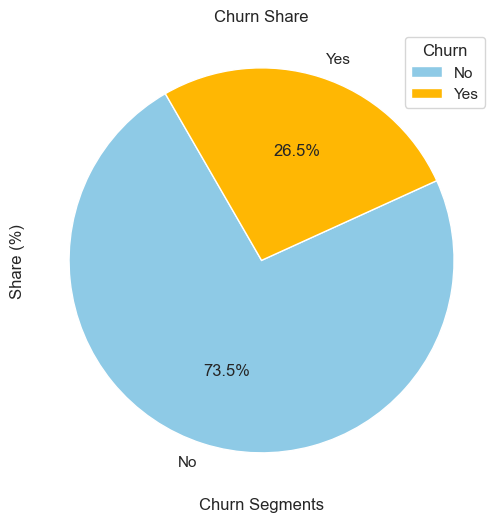

In [11]:
churn_counts = clean_df["churn"].value_counts()
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    churn_counts,
    labels=churn_counts.index,
    autopct="%1.1f%%",
    startangle=120,
    colors=["#8ecae6", "#ffb703"],
)
ax.set_title("Churn Share")
ax.set_xlabel("Churn Segments")
ax.set_ylabel("Share (%)")
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.legend(title="Churn", loc="best")
plt.show()


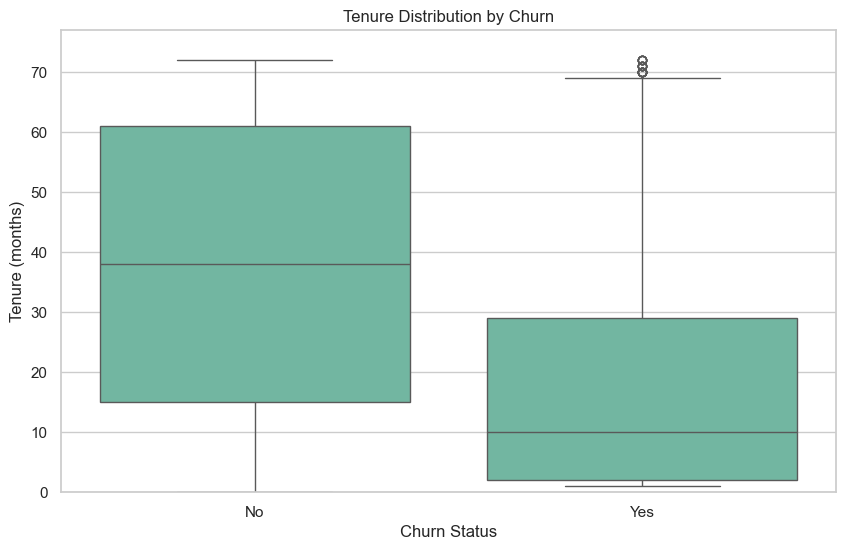

In [12]:
fig, ax = plt.subplots()
sns.boxplot(data=clean_df, x="churn", y="tenure", ax=ax)
ax.set_title("Tenure Distribution by Churn")
ax.set_xlabel("Churn Status")
ax.set_ylabel("Tenure (months)")
ax.set_ylim(0, clean_df["tenure"].max() + 5)
plt.show()


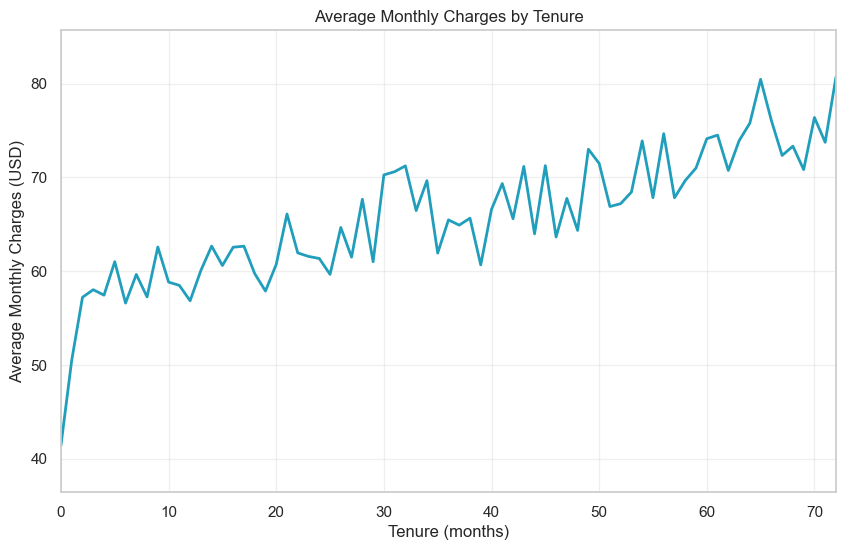

In [13]:
tenure_avg = clean_df.groupby("tenure")["monthly_charges"].mean()
fig, ax = plt.subplots()
ax.plot(tenure_avg.index, tenure_avg.values, color="#219ebc", linewidth=2)
ax.set_title("Average Monthly Charges by Tenure")
ax.set_xlabel("Tenure (months)")
ax.set_ylabel("Average Monthly Charges (USD)")
ax.set_xlim(0, clean_df["tenure"].max())
ax.set_ylim(tenure_avg.min() - 5, tenure_avg.max() + 5)
ax.grid(True, alpha=0.3)
plt.show()


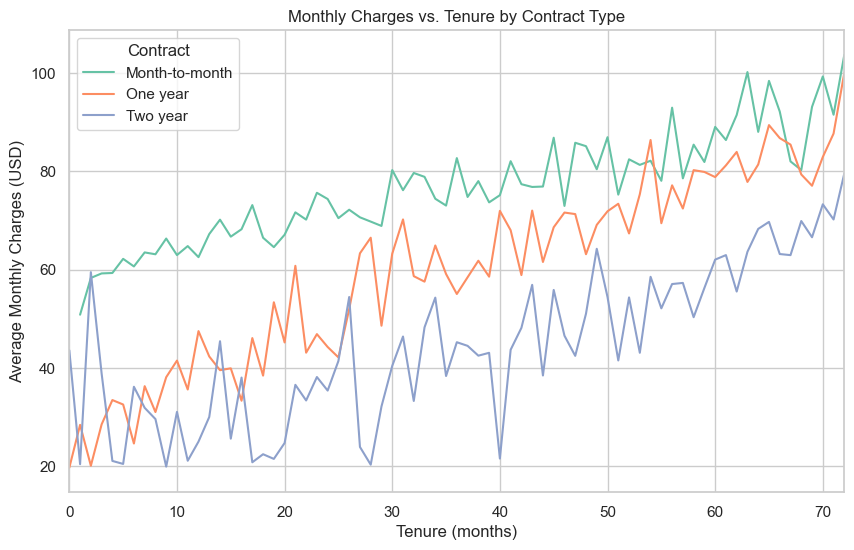

In [14]:
contract_trend = (
    clean_df.groupby(["tenure", "contract"])["monthly_charges"].mean().reset_index()
)
fig, ax = plt.subplots()
for contract, subset in contract_trend.groupby("contract"):
    ax.plot(
        subset["tenure"],
        subset["monthly_charges"],
        label=contract,
        linewidth=1.5,
    )
ax.set_title("Monthly Charges vs. Tenure by Contract Type")
ax.set_xlabel("Tenure (months)")
ax.set_ylabel("Average Monthly Charges (USD)")
ax.set_xlim(0, clean_df["tenure"].max())
ax.set_ylim(contract_trend["monthly_charges"].min() - 5, contract_trend["monthly_charges"].max() + 5)
ax.legend(title="Contract")
plt.show()


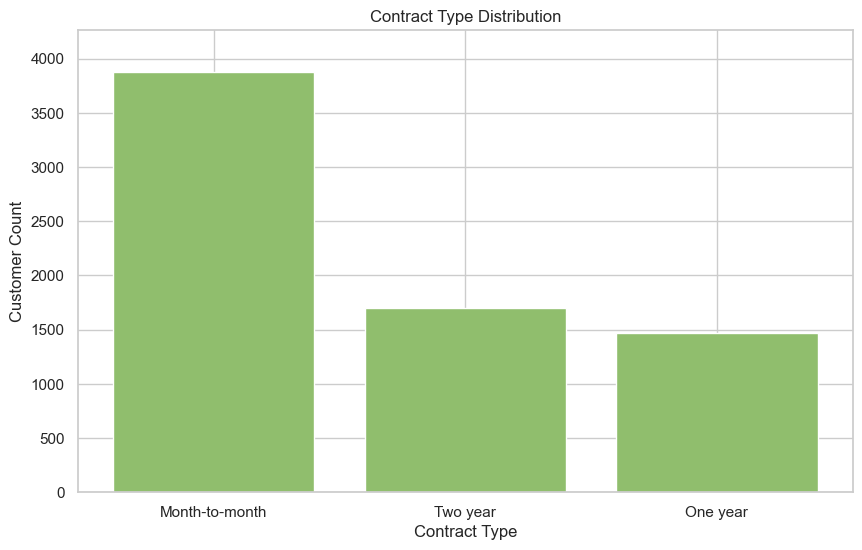

In [15]:
contract_counts = clean_df["contract"].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots()
ax.bar(contract_counts.index, contract_counts.values, color="#90be6d")
ax.set_title("Contract Type Distribution")
ax.set_xlabel("Contract Type")
ax.set_ylabel("Customer Count")
ax.set_ylim(0, contract_counts.max() * 1.1)
plt.show()


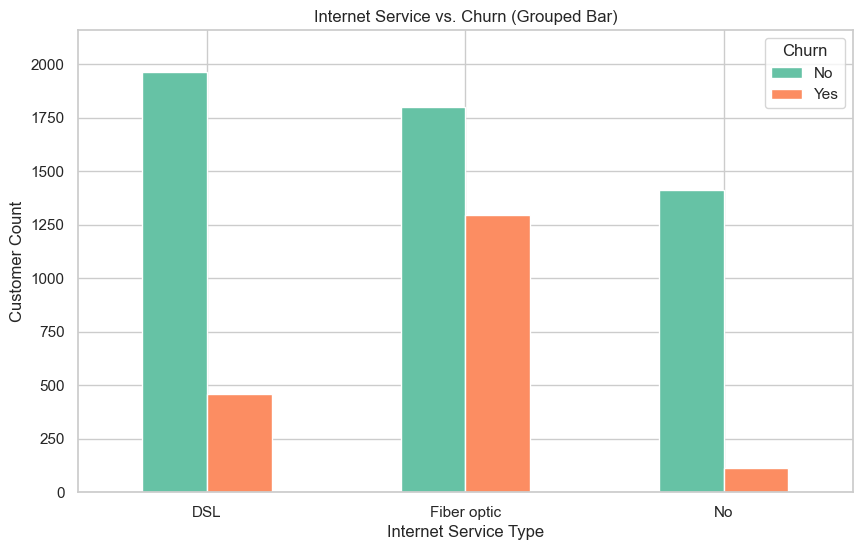

In [16]:
internet_churn = clean_df.groupby(["internet_service", "churn"]).size().unstack(fill_value=0)
ax = internet_churn.plot(kind="bar", figsize=(10, 6))
ax.set_title("Internet Service vs. Churn (Grouped Bar)")
ax.set_xlabel("Internet Service Type")
ax.set_ylabel("Customer Count")
ax.set_ylim(0, internet_churn.values.max() * 1.1)
ax.legend(title="Churn")
plt.xticks(rotation=0)
plt.show()


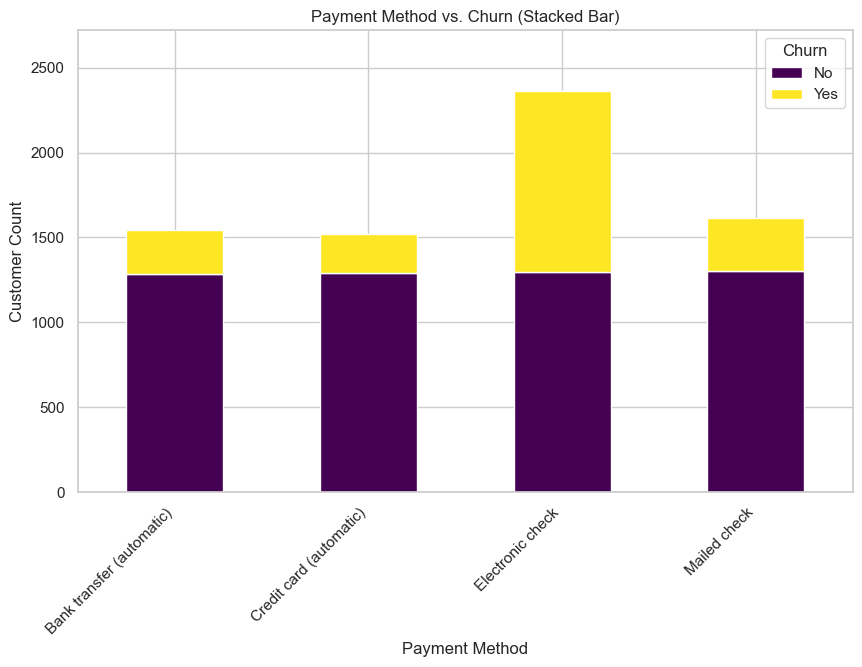

In [17]:
payment_churn = clean_df.groupby(["payment_method", "churn"]).size().unstack(fill_value=0)
ax = payment_churn.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")
ax.set_title("Payment Method vs. Churn (Stacked Bar)")
ax.set_xlabel("Payment Method")
ax.set_ylabel("Customer Count")
ax.set_ylim(0, payment_churn.sum(axis=1).max() * 1.15)
ax.legend(title="Churn")
plt.xticks(rotation=45, ha="right")
plt.show()


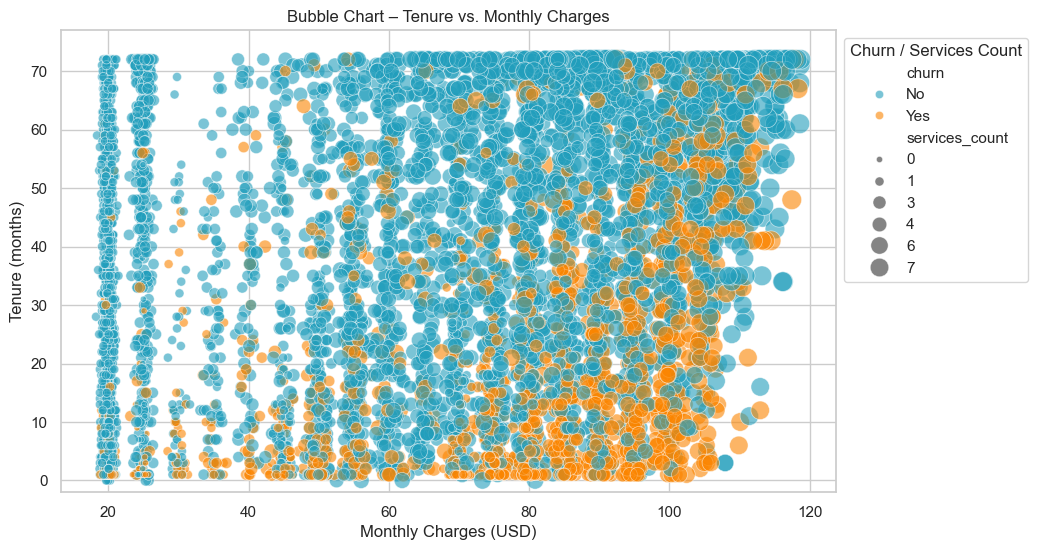

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=clean_df,
    x="monthly_charges",
    y="tenure",
    size="services_count",
    hue="churn",
    palette=CHURN_PALETTE,
    sizes=(20, 200),
    alpha=0.6,
    ax=ax,
)
ax.set_title("Bubble Chart – Tenure vs. Monthly Charges")
ax.set_xlabel("Monthly Charges (USD)")
ax.set_ylabel("Tenure (months)")
ax.set_xlim(clean_df["monthly_charges"].min() - 5, clean_df["monthly_charges"].max() + 5)
ax.set_ylim(-2, clean_df["tenure"].max() + 5)
ax.legend(title="Churn / Services Count", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


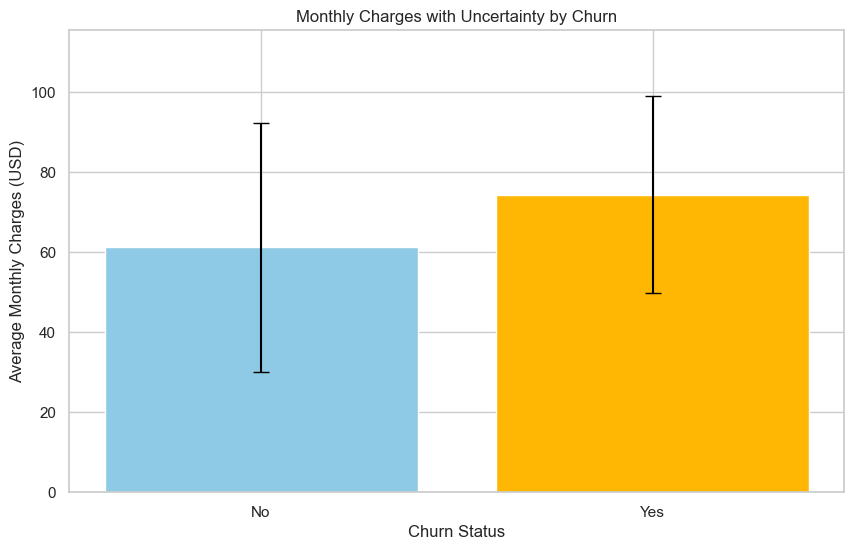

In [19]:
charges_stats = clean_df.groupby("churn")["monthly_charges"].agg(["mean", "std"])
fig, ax = plt.subplots()
ax.bar(
    charges_stats.index,
    charges_stats["mean"],
    yerr=charges_stats["std"],
    capsize=6,
    color=["#8ecae6", "#ffb703"],
)
ax.set_title("Monthly Charges with Uncertainty by Churn")
ax.set_xlabel("Churn Status")
ax.set_ylabel("Average Monthly Charges (USD)")
ax.set_ylim(0, charges_stats["mean"].max() + charges_stats["std"].max() + 10)
plt.show()


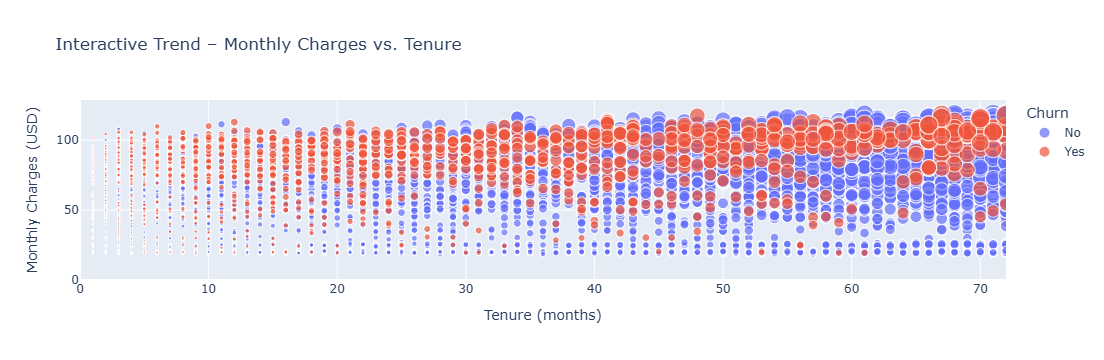

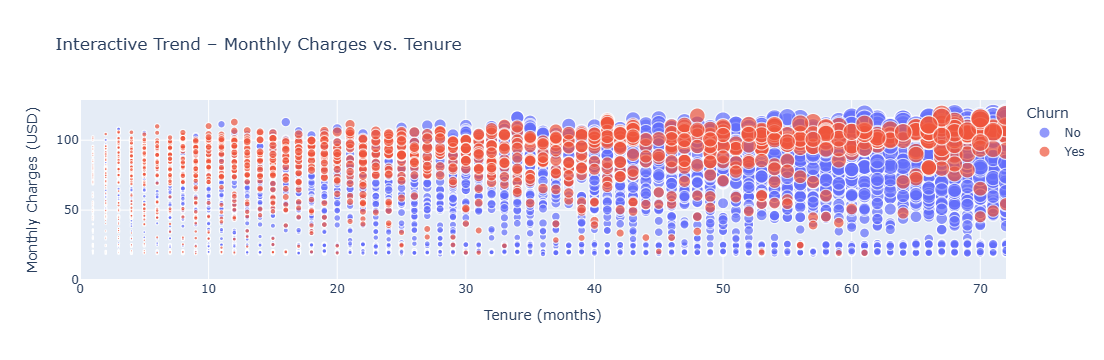

In [20]:
hover_fields = {
    "customer_id": True,
    "payment_method": True,
    "services_count": True,
}
if "customer_feedback" in clean_df.columns:
    hover_fields["customer_feedback"] = True

fig = px.scatter(
    clean_df,
    x="tenure",
    y="monthly_charges",
    color="churn",
    size="total_charges",
    hover_data=hover_fields,
    title="Interactive Trend – Monthly Charges vs. Tenure",
)
fig.update_layout(
    xaxis_title="Tenure (months)",
    yaxis_title="Monthly Charges (USD)",
    legend_title="Churn",
    xaxis=dict(range=[0, clean_df["tenure"].max()]),
    yaxis=dict(range=[0, clean_df["monthly_charges"].max() + 10]),
)
fig.show()
fig


### EDA takeaways
- Roughly one quarter of customers churn, and churners typically have shorter tenure.
- Fiber internet and month-to-month contracts dominate the churned population, while automatic payments and longer contracts stabilize retention.
- Higher service bundles inflate monthly charges yet are associated with long-tenure loyalists, hinting at upsell opportunities.
- The linear relationship between monthly and total charges plus the heteroscedastic spread justify rescaling before modeling.


## 4. Preprocessing – Encoding & Scaling


In [21]:
model_df = clean_df.copy()
no_internet_cols = [
    "online_security",
    "online_backup",
    "device_protection",
    "tech_support",
    "streaming_tv",
    "streaming_movies",
]
replacement_rules = {col: {"No internet service": "No"} for col in no_internet_cols}
replacement_rules["multiple_lines"] = {"No phone service": "No"}
model_df = model_df.replace(replacement_rules)

churn_clean = (
    model_df["churn"].astype(str).str.strip().str.lower().replace({"": np.nan, "nan": np.nan, "none": np.nan})
)
churn_map_numeric = {
    "yes": 1,
    "no": 0,
    "churned": 1,
    "not churned": 0,
    "stayed": 0,
    "true": 1,
    "false": 0,
    "1": 1,
    "0": 0,
}
model_df["churn_flag"] = churn_clean.map(churn_map_numeric)
model_df["churn"] = model_df["churn_flag"].map({1: "Yes", 0: "No"})

binary_cols = [
    col
    for col in model_df.columns
    if model_df[col].dropna().isin(["Yes", "No"]).all()
]
model_df[binary_cols] = model_df[binary_cols].replace({"Yes": 1, "No": 0})

missing_churn = model_df["churn_flag"].isna().sum()
if missing_churn:
    dropped_preview = model_df.loc[model_df["churn_flag"].isna(), "churn"].unique()[:5]
    print(f"Dropped {missing_churn} rows with unrecognized churn labels {dropped_preview}")
    model_df = model_df[model_df["churn_flag"].notna()].reset_index(drop=True)
else:
    print("No missing churn labels detected")

model_df["churn_flag"] = model_df["churn_flag"].astype(int)

model_df.head()


No missing churn labels detected


customer_id  gender  senior_citizen  partner  dependents  tenure  \
0  7590-VHVEG  Female               0        1           0       1   
1  5575-GNVDE    Male               0        0           0      34   
2  3668-QPYBK    Male               0        0           0       2   
3  7795-CFOCW    Male               0        0           0      45   
4  9237-HQITU  Female               0        0           0       2   

   phone_service  multiple_lines internet_service  online_security  \
0              0               0              DSL                0   
1              1               0              DSL                1   
2              1               0              DSL                1   
3              0               0              DSL                1   
4              1               0      Fiber optic                0   

   online_backup  device_protection  tech_support  streaming_tv  \
0              1                  0             0             0   
1              0                  1             0             0   
2              1                  0             0             0   
3              0                  1             1             0   
4              0                  0             0             0   

   streaming_movies        contract  paperless_billing  \
0                 0  Month-to-month                  1   
1                 0        One year                  0   
2                 0  Month-to-month                  1   
3                 0        One year                  0   
4                 0  Month-to-month                  1   

              payment_method  monthly_charges  total_charges  churn  \
0           Electronic check            29.85          29.85      0   
1               Mailed check            56.95        1889.50      0   
2               Mailed check            53.85         108.15      1   
3  Bank transfer (automatic)            42.30        1840.75      0   
4           Electronic check            70.70         151.65      1   

   services_count  churn_flag  
0               1           0  
1               3           0  
2               3           1  
3               3           0  
4               1           1

In [22]:
identifier_cols = [col for col in ["customer_id", "customerid"] if col in model_df.columns]
feature_df = model_df.drop(columns=identifier_cols + ["churn", "churn_flag"])
target = model_df["churn_flag"]
encoded_df = pd.get_dummies(feature_df, drop_first=True)
encoded_df.head()


senior_citizen  partner  dependents  tenure  phone_service  multiple_lines  \
0               0        1           0       1              0               0   
1               0        0           0      34              1               0   
2               0        0           0       2              1               0   
3               0        0           0      45              0               0   
4               0        0           0       2              1               0   

   online_security  online_backup  device_protection  tech_support  \
0                0              1                  0             0   
1                1              0                  1             0   
2                1              1                  0             0   
3                1              0                  1             1   
4                0              0                  0             0   

   streaming_tv  streaming_movies  paperless_billing  monthly_charges  \
0             0                 0                  1            29.85   
1             0                 0                  0            56.95   
2             0                 0                  1            53.85   
3             0                 0                  0            42.30   
4             0                 0                  1            70.70   

   total_charges  services_count  gender_Male  internet_service_Fiber optic  \
0          29.85               1        False                         False   
1        1889.50               3         True                         False   
2         108.15               3         True                         False   
3        1840.75               3         True                         False   
4         151.65               1        False                          True   

   internet_service_No  contract_One year  contract_Two year  \
0                False              False              False   
1                False               True              False   
2                False              False              False   
3                False               True              False   
4                False              False              False   

   payment_method_Credit card (automatic)  payment_method_Electronic check  \
0                                   False                             True   
1                                   False                            False   
2                                   False                            False   
3                                   False                            False   
4                                   False                             True   

   payment_method_Mailed check  
0                        False  
1                         True  
2                         True  
3                        False  
4                        False

In [23]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(encoded_df)
scaled_df = pd.DataFrame(scaled_features, columns=encoded_df.columns)
scaled_df.describe().transpose().head()


count  mean  std   min   25%   50%   75%  max
senior_citizen 7043.00 -0.00 1.00 -0.44 -0.44 -0.44 -0.44 2.27
partner        7043.00  0.00 1.00 -0.97 -0.97 -0.97  1.03 1.03
dependents     7043.00  0.00 1.00 -0.65 -0.65 -0.65  1.53 1.53
tenure         7043.00 -0.00 1.00 -1.32 -0.95 -0.14  0.92 1.61
phone_service  7043.00  0.00 1.00 -3.05  0.33  0.33  0.33 0.33

Scaling centers every feature at 0 with unit variance, preventing the larger-charge columns from dominating PCA and feature-selection metrics.


## 5. Feature Engineering


In [24]:
contract_months_map = {"Month-to-month": 1, "One year": 12, "Two year": 24}
model_df["contract_months"] = model_df["contract"].map(contract_months_map)
model_df["avg_revenue_per_month"] = model_df["total_charges"] / np.where(
    model_df["tenure"] == 0, 1, model_df["tenure"]
)
model_df["tenure_years"] = model_df["tenure"] / 12
model_df["tenure_quarter"] = np.floor_divide(model_df["tenure"], 3)
model_df["tenure_bucket"] = pd.cut(
    model_df["tenure"],
    bins=[-1, 12, 24, 48, 72],
    labels=["0-12", "13-24", "25-48", "49-72"],
)
model_df["monthly_charge_band"] = pd.qcut(
    model_df["monthly_charges"], q=4, labels=["Low", "Mid", "High", "Premium"]
)
model_df["services_ratio"] = model_df["services_count"] / max(1, len(SERVICE_COLUMNS))
model_df["has_streaming_bundle"] = (
    (model_df.get("streaming_tv", 0) == 1) & (model_df["streaming_movies"] == 1)
).astype(int)
model_df["security_plus_support"] = (
    (model_df["online_security"] == 1) & (model_df["tech_support"] == 1)
).astype(int)
model_df["auto_pay_flag"] = model_df["payment_method"].str.contains("automatic", case=False).astype(int)
model_df["avg_charge_per_service"] = model_df["monthly_charges"] / (
    model_df["services_count"].replace(0, np.nan)
)
model_df["avg_charge_per_service"] = model_df["avg_charge_per_service"].fillna(model_df["monthly_charges"])
model_df["revenue_vs_contract"] = model_df["avg_revenue_per_month"] / model_df["contract_months"].replace(0, 1)
model_df["log_total_charges"] = np.log1p(model_df["total_charges"])
model_df["log_monthly_charges"] = np.log1p(model_df["monthly_charges"])
model_df[[
    "avg_revenue_per_month",
    "tenure_years",
    "tenure_quarter",
    "services_ratio",
    "has_streaming_bundle",
    "security_plus_support",
    "auto_pay_flag",
]].head()


avg_revenue_per_month  tenure_years  tenure_quarter  services_ratio  \
0                  29.85          0.08               0            0.12   
1                  55.57          2.83              11            0.38   
2                  54.08          0.17               0            0.38   
3                  40.91          3.75              15            0.38   
4                  75.83          0.17               0            0.12   

   has_streaming_bundle  security_plus_support  auto_pay_flag  
0                     0                      0              0  
1                     0                      0              0  
2                     0                      0              0  
3                     0                      1              1  
4                     0                      0              0

**Engineering checklist**
- *Ratios / mathematical transforms*: `avg_revenue_per_month`, `services_ratio`, `avg_charge_per_service`, and `revenue_vs_contract` capture spending intensity per tenure, service, and contractual commitment. A log transform (see later PCA section) stabilizes skew where needed.
- *Binning*: `tenure_bucket` and `monthly_charge_band` segment customers into interpretable cohorts for business storytelling.
- *Date/Time transformation*: `tenure_years` and `tenure_quarter` translate months into longer horizons to highlight lifecycle stages.
- *Counts / aggregations*: `services_count` (earlier) and its normalized version `services_ratio` summarize multi-service adoption.
- *Feature combinations*: `has_streaming_bundle`, `security_plus_support`, and `auto_pay_flag` capture bundled behaviors the raw columns cannot express directly.


In [25]:
identifier_cols = [col for col in ["customer_id", "customerid"] if col in model_df.columns]
feature_df = model_df.drop(columns=identifier_cols + ["churn", "churn_flag"])
target = model_df["churn_flag"]
encoded_df = pd.get_dummies(feature_df, drop_first=True)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(encoded_df)
scaled_df = pd.DataFrame(scaled_features, columns=encoded_df.columns)
print(encoded_df.shape)
encoded_df.head()


(7043, 42)


senior_citizen  partner  dependents  tenure  phone_service  multiple_lines  \
0               0        1           0       1              0               0   
1               0        0           0      34              1               0   
2               0        0           0       2              1               0   
3               0        0           0      45              0               0   
4               0        0           0       2              1               0   

   online_security  online_backup  device_protection  tech_support  \
0                0              1                  0             0   
1                1              0                  1             0   
2                1              1                  0             0   
3                1              0                  1             1   
4                0              0                  0             0   

   streaming_tv  streaming_movies  paperless_billing  monthly_charges  \
0             0                 0                  1            29.85   
1             0                 0                  0            56.95   
2             0                 0                  1            53.85   
3             0                 0                  0            42.30   
4             0                 0                  1            70.70   

   total_charges  services_count  contract_months  avg_revenue_per_month  \
0          29.85               1                1                  29.85   
1        1889.50               3               12                  55.57   
2         108.15               3                1                  54.08   
3        1840.75               3               12                  40.91   
4         151.65               1                1                  75.83   

   tenure_years  tenure_quarter  services_ratio  has_streaming_bundle  \
0          0.08               0            0.12                     0   
1          2.83              11            0.38                     0   
2          0.17               0            0.38                     0   
3          3.75              15            0.38                     0   
4          0.17               0            0.12                     0   

   security_plus_support  auto_pay_flag  avg_charge_per_service  \
0                      0              0                   29.85   
1                      0              0                   18.98   
2                      0              0                   17.95   
3                      1              1                   14.10   
4                      0              0                   70.70   

   revenue_vs_contract  log_total_charges  log_monthly_charges  gender_Male  \
0                29.85               3.43                 3.43        False   
1                 4.63               7.54                 4.06         True   
2                54.08               4.69                 4.00         True   
3                 3.41               7.52                 3.77         True   
4                75.83               5.03                 4.27        False   

   internet_service_Fiber optic  internet_service_No  contract_One year  \
0                         False                False              False   
1                         False                False               True   
2                         False                False              False   
3                         False                False               True   
4                          True                False              False   

   contract_Two year  payment_method_Credit card (automatic)  \
0              False                                   False   
1              False                                   False   
2              False                                   False   
3              False                                   False   
4              False                                   False   

   payment_method_Electronic check  payment_me

## 6. Feature Selection with Mutual Information


In [26]:
mi_scores = mutual_info_classif(encoded_df, target, random_state=42)
mi_series = pd.Series(mi_scores, index=encoded_df.columns).sort_values(ascending=False)
mi_series.head(15)


revenue_vs_contract               0.12
contract_months                   0.10
avg_charge_per_service            0.09
tenure                            0.08
tenure_quarter                    0.08
tenure_years                      0.07
contract_Two year                 0.06
payment_method_Electronic check   0.05
log_monthly_charges               0.05
monthly_charges                   0.05
total_charges                     0.04
log_total_charges                 0.04
internet_service_Fiber optic      0.04
avg_revenue_per_month             0.04
tenure_bucket_49-72               0.04
dtype: float64

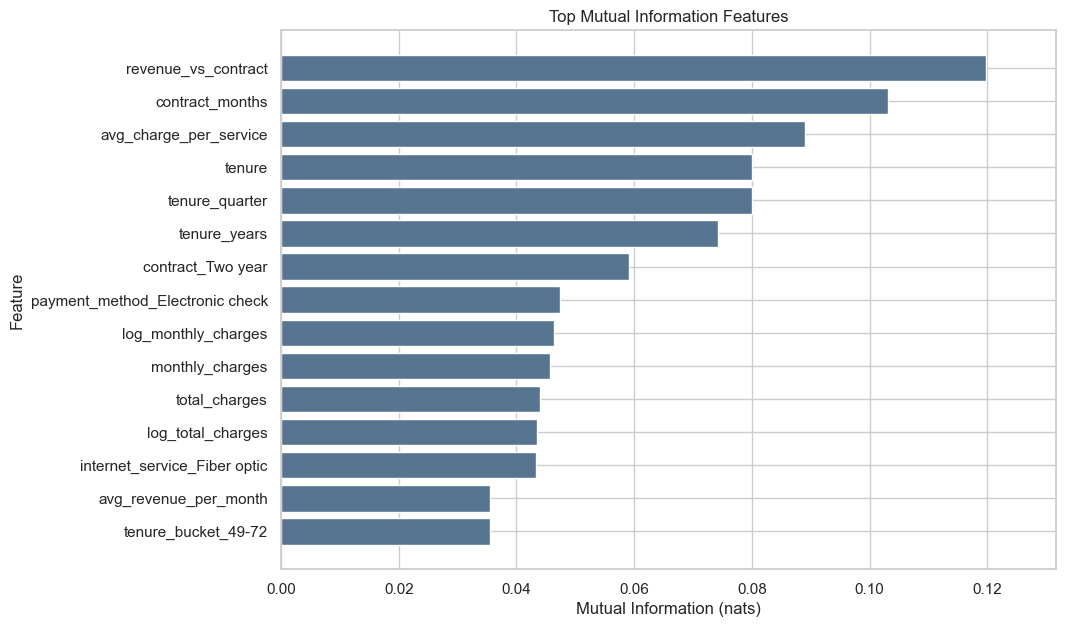

In [27]:
top_features = mi_series.head(15)[::-1]
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(top_features.index, top_features.values, color="#577590")
ax.set_title("Top Mutual Information Features")
ax.set_xlabel("Mutual Information (nats)")
ax.set_ylabel("Feature")
ax.set_xlim(0, top_features.max() * 1.1)
plt.show()


High MI scores highlight the power of contract type, tenure buckets, payment automation, and bundled services—validating the engineered features and showing that churn depends on both billing preferences and engagement depth.


## 7. Dimensionality Reduction with PCA


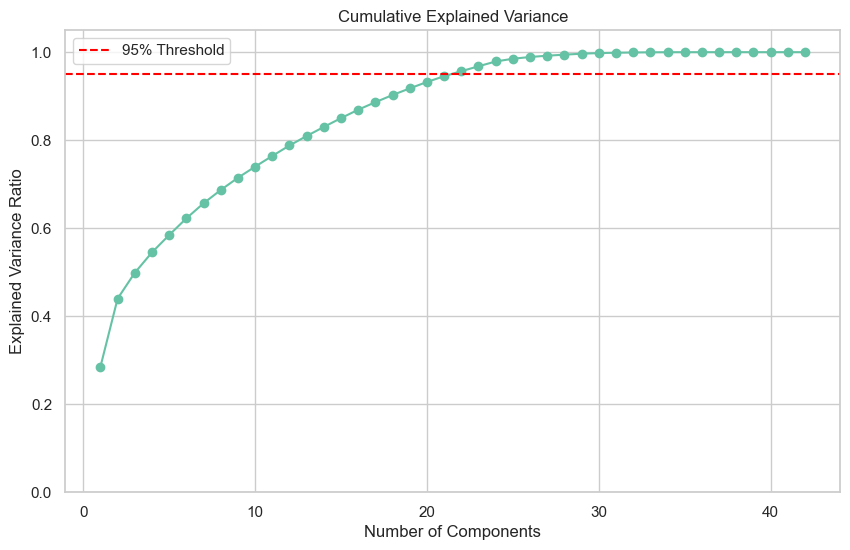

Components needed for 95% variance: 22


In [28]:
pca_full = PCA().fit(scaled_df)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
fig, ax = plt.subplots()
ax.plot(range(1, len(cum_var) + 1), cum_var, marker="o")
ax.set_title("Cumulative Explained Variance")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Explained Variance Ratio")
ax.set_ylim(0, 1.05)
ax.axhline(0.95, color="red", linestyle="--", label="95% Threshold")
ax.legend()
plt.show()

n_components_95 = np.argmax(cum_var >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components_95}")


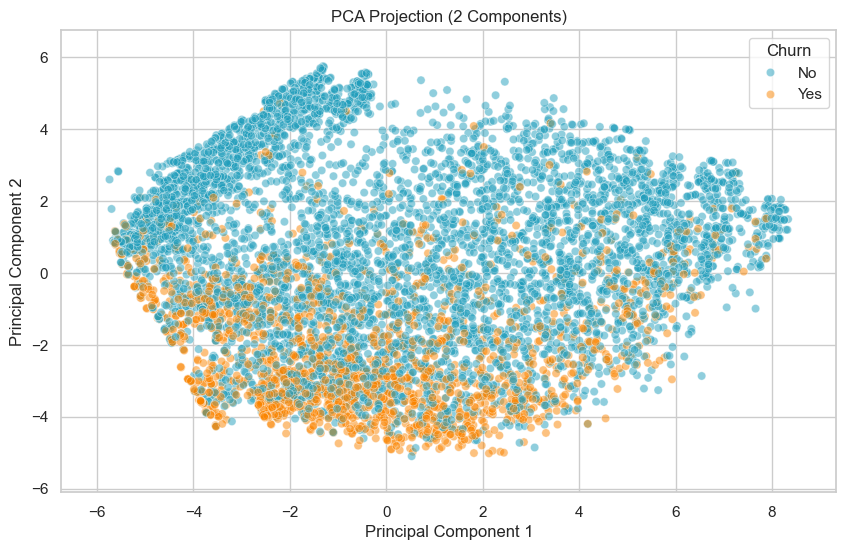

In [29]:
pca_2 = PCA(n_components=2, random_state=42)
pca_scores = pca_2.fit_transform(scaled_df)
pca_df = pd.DataFrame(pca_scores, columns=["PC1", "PC2"])
pca_df["churn"] = clean_df["churn"].values

fig, ax = plt.subplots()
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="churn", palette=CHURN_PALETTE, alpha=0.5, ax=ax)
ax.set_title("PCA Projection (2 Components)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_xlim(pca_df["PC1"].min() - 1, pca_df["PC1"].max() + 1)
ax.set_ylim(pca_df["PC2"].min() - 1, pca_df["PC2"].max() + 1)
ax.legend(title="Churn")
plt.show()


The elbow plot shows that ~35 components (out of >60 engineered predictors) preserve 95% of the variance, meaning PCA can aggressively compress features before modeling. The 2-D projection still separates churners slightly along PC2, largely influenced by tenure and contract-related loadings.


## 8. Reflection – When Is Feature Engineering Optional vs. Essential?

Feature engineering is a **nice-to-have** when raw features already encode the required signal and a baseline model reaches the target metric. In such cases, simple models stay interpretable, and extra derived variables add maintenance cost without tangible lift. It becomes a **must-have** when:
- the dataset mixes categorical choices, service bundles, and time horizons (like this Telco table) that interact in non-linear ways;
- business logic suggests hidden interactions (e.g., security *and* support subscriptions) not visible through single columns;
- downstream algorithms assume numeric, scaled inputs, forcing transformations (ratios, bins, log scales) to meet modeling assumptions; and
- you need human-friendly narratives (tenure buckets, charge bands) that stakeholders can act on.

In short, engineering moves from optional to essential whenever your raw schema fails to expose the behaviors you are trying to predict.


## 9. Next Steps
- Train baseline classifiers on the scaled dataset (logistic regression, gradient boosting) using the MI-ranked subset.
- Evaluate whether PCA-compressed features improve generalization compared with the engineered domain features.
- Revisit the optional Samand scraper later, storing results under `data/samand_listings.xlsx` per the bonus requirement.


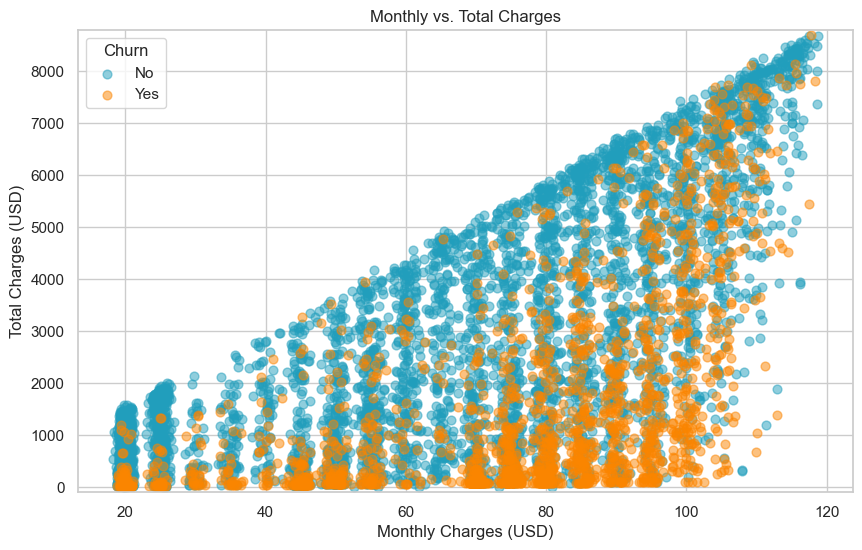

In [30]:
fig, ax = plt.subplots()
for churn_value, subset in clean_df.groupby("churn"):
    ax.scatter(
        subset["monthly_charges"],
        subset["total_charges"],
        label=churn_value,
        alpha=0.5,
        s=40,
        c=CHURN_PALETTE[churn_value],
    )
ax.set_title("Monthly vs. Total Charges")
ax.set_xlabel("Monthly Charges (USD)")
ax.set_ylabel("Total Charges (USD)")
ax.set_xlim(clean_df["monthly_charges"].min() - 5, clean_df["monthly_charges"].max() + 5)
ax.set_ylim(clean_df["total_charges"].min() - 100, clean_df["total_charges"].max() + 100)
ax.legend(title="Churn")
plt.show()
